Download and crop images

In [35]:
# Provided by ChatGPT
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import os

def download_image(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return Image.open(BytesIO(response.content))
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {url}: {e}")
        return None

def crop_and_save_image(image, bbox, save_path):
    width, height = image.size
    left = bbox[0] * width
    top = bbox[2] * height
    right = bbox[1] * width
    bottom = bbox[3] * height
    
    cropped_image = image.crop((left, top, right, bottom))
    cropped_image.save(save_path)

def process_csv(file_path, output_dir):
    # Read the first 10 lines of the CSV file
    df = pd.read_csv(file_path, header=None, nrows=10)
    
    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        for i in range(0, len(row) - 5, 5):
            url = row[i]
            # Ensure the value is a string before checking if it is a valid URL
            if not isinstance(url, str) or not url.startswith("http"): 
                print(f"Skipping invalid URL: {url}")
                continue
            
            bbox = [row[i+1], row[i+2], row[i+3], row[i+4]]
            
            # Download the image
            image = download_image(url)
            if image is None:
                continue
            
            # Create output directory if it doesn't exist
            os.makedirs(output_dir, exist_ok=True)
            
            # Define save path for cropped image
            save_path = os.path.join(output_dir, f"cropped_face_{index}_{i//5}.jpg")
            
            # Crop and save the image
            crop_and_save_image(image, bbox, save_path)
            print(f"Saved cropped face to {save_path}")





if __name__ == "__main__":
    # Path to your CSV file
    csv_file_path = "./FEC_dataset/faceexp-comparison-data-train-public.csv"
    # Directory to save cropped face images
    output_directory = "cropped_faces"
    
    process_csv(csv_file_path, output_directory)

Saved cropped face to cropped_faces/cropped_face_0_0.jpg
Saved cropped face to cropped_faces/cropped_face_0_1.jpg
Saved cropped face to cropped_faces/cropped_face_0_2.jpg
Skipping invalid URL: ONE_CLASS_TRIPLET
Skipping invalid URL: 321402
Saved cropped face to cropped_faces/cropped_face_1_0.jpg
Saved cropped face to cropped_faces/cropped_face_1_1.jpg
Saved cropped face to cropped_faces/cropped_face_1_2.jpg
Skipping invalid URL: TWO_CLASS_TRIPLET
Skipping invalid URL: 321601
Saved cropped face to cropped_faces/cropped_face_2_0.jpg
Saved cropped face to cropped_faces/cropped_face_2_1.jpg
Saved cropped face to cropped_faces/cropped_face_2_2.jpg
Skipping invalid URL: ONE_CLASS_TRIPLET
Skipping invalid URL: 322102
Saved cropped face to cropped_faces/cropped_face_3_0.jpg
Saved cropped face to cropped_faces/cropped_face_3_1.jpg
Saved cropped face to cropped_faces/cropped_face_3_2.jpg
Skipping invalid URL: TWO_CLASS_TRIPLET
Skipping invalid URL: 321601
Saved cropped face to cropped_faces/crop

Load Grayscale image and 2D fourier transform it

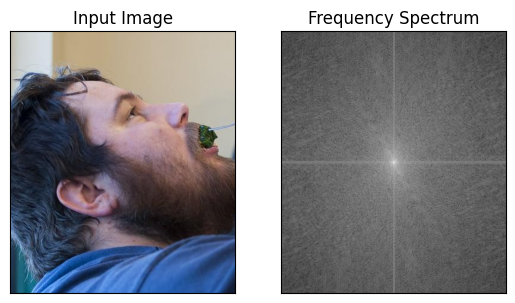

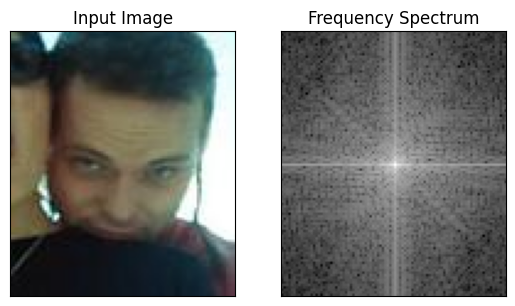

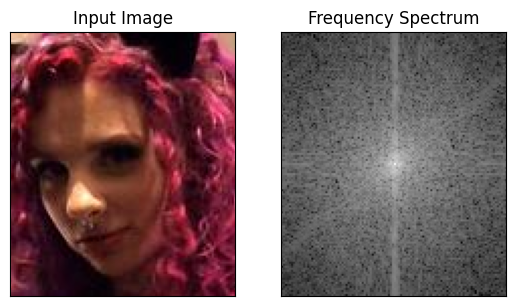

In [36]:
from PIL import Image
import PIL
import PIL.ImageOps
import numpy as np
from matplotlib import pyplot as plt

def transform_and_plot_image(path: str):
    img = Image.open(path)
    grayscale = PIL.ImageOps.grayscale(img)
    # grayscale.show()
    fourier_transformed = np.fft.fft2(grayscale)
    fourier_transformed = np.fft.fftshift(fourier_transformed)
    fourier_transformed = 20*np.log(np.abs(fourier_transformed))
    plt.subplot(121),plt.imshow(img, cmap = 'gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(fourier_transformed, cmap = 'gray')
    plt.title('Frequency Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

transform_and_plot_image("./cropped_faces/cropped_face_6_1.jpg")
transform_and_plot_image("./cropped_faces/cropped_face_9_1.jpg")
transform_and_plot_image("./cropped_faces/cropped_face_3_1.jpg")

Low pass filter

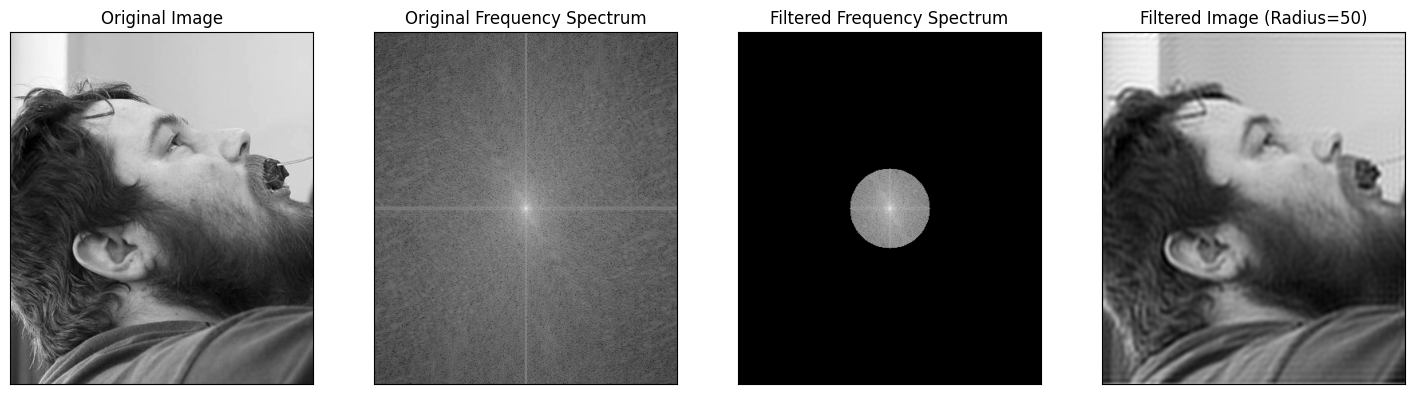

In [37]:
import numpy as np
import cv2
from PIL import Image
import PIL.ImageOps
from matplotlib import pyplot as plt

def apply_low_pass_filter_and_plot(path: str, radius: int):
    # Load the image and convert to grayscale
    img = Image.open(path)
    grayscale = PIL.ImageOps.grayscale(img)
    
    # Convert grayscale image to numpy array
    img_np = np.array(grayscale)
    
    # Apply 2D Fourier Transform
    dft = np.fft.fft2(img_np)
    dft_shifted = np.fft.fftshift(dft)  # Shift zero frequency component to the center
    
    # Get image dimensions
    rows, cols = img_np.shape
    crow, ccol = rows // 2 , cols // 2  # Center of the image
    
    # Create a low-pass filter (mask)
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), radius, 1, thickness=-1)  # Draw a filled circle at the center
    
    # Apply the mask (low-pass filter)
    dft_shifted_filtered = dft_shifted * mask
    
    # Inverse DFT to get the filtered image
    dft_inverse = np.fft.ifftshift(dft_shifted_filtered)  # Shift back the zero frequency
    img_filtered = np.fft.ifft2(dft_inverse)
    img_filtered = np.abs(img_filtered)
    
    # Plot the results
    plt.figure(figsize=(18, 6))
    
    # Original Image
    plt.subplot(141), plt.imshow(grayscale, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    # Frequency Spectrum (Magnitude) - Original
    magnitude_spectrum = 20 * np.log(np.abs(dft_shifted))
    plt.subplot(142), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Original Frequency Spectrum'), plt.xticks([]), plt.yticks([])

    # Frequency Spectrum (Magnitude) - After Low Pass Filter
    filtered_magnitude_spectrum = 20 * np.log(np.abs(dft_shifted_filtered) + 1)  # Add 1 to avoid log(0)
    plt.subplot(143), plt.imshow(filtered_magnitude_spectrum, cmap='gray')
    plt.title('Filtered Frequency Spectrum'), plt.xticks([]), plt.yticks([])

    # Filtered Image
    plt.subplot(144), plt.imshow(img_filtered, cmap='gray')
    plt.title(f'Filtered Image (Radius={radius})'), plt.xticks([]), plt.yticks([])

    plt.show()

# Apply the function to an image
apply_low_pass_filter_and_plot("./cropped_faces/cropped_face_6_1.jpg", 50)  # You can adjust the radius for filtering strength